In [9]:
from typing import Annotated, Dict, TypedDict, Sequence
from langgraph.graph import StateGraph, START,END, add_messages
from langchain_ollama import ChatOllama

In [10]:
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool

In [11]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Should be imported from langchain_core.tools not from langhain_core.messages

@tool
def add_node(x: int, y: int):
    """Use this tool to add 2 numbers"""
    return x+y

@tool
def multiply_node(x: int, y: int):
    """Use this tool to multiply 2 numbers"""
    return x*y


tools = [add_node, multiply_node]

llm = ChatOllama(
    base_url="http://localhost:11434/",
    model="qwen3:1.7b",
    temperature=0
).bind_tools(tools=tools)


def call_llm(state: AgentState) -> AgentState: 
    system_message = SystemMessage(content="You are a coding assistant. Based on the user query, pick the right tools to get the context and answer")
    response = llm.invoke(
        [system_message] + state["messages"]
    )
    return {"messages": [response]}

In [12]:
# conditional edge - function to decide where to go next
# Logic -  If the last message has tool_calls, then it should go to that tool. else END

def should_continue(state: AgentState):
    """This is a conditional edge. Decides it should loop or not"""
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return "END"
    else:
        return "continue"
    


In [13]:
# Construct the graph
graph = StateGraph(AgentState)

graph.add_node("call_model",call_llm)

tool_node = ToolNode(tools=tools)
graph.add_node("tool_node", tool_node)

graph.add_edge(START, "call_model")
graph.add_conditional_edges(
    "call_model",
    should_continue,
    {
        "continue": "tool_node",
        "END": END
    }
)
graph.add_edge("tool_node", "call_model")

agent = graph.compile()

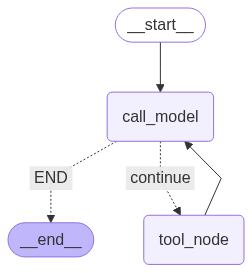

In [14]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

In [15]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()



In [20]:

inputs = {"messages": [("user", "Add 40 + 12 and tell me a joke. multiply 6 with 8")]}
print_stream(agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12 and tell me a joke. multiply 6 with 8
================================== Ai Message ==================================
Tool Calls:
  add_node (a1b38f04-534a-47e2-9e51-4e5f884d9aab)
 Call ID: a1b38f04-534a-47e2-9e51-4e5f884d9aab
  Args:
    x: 40
    y: 12
  multiply_node (eefb93bd-8f5c-45b1-a893-98774c49566c)
 Call ID: eefb93bd-8f5c-45b1-a893-98774c49566c
  Args:
    x: 6
    y: 8
================================= Tool Message =================================
Name: multiply_node

48
================================== Ai Message ==================================

<think>
Okay, let's see. The user asked to add 40 + 12 and tell a joke, then multiply 6 with 8. I called the add_node function for 40 and 12, which gave 52. Then I called multiply_node for 6 and 8, which gave 48. Now the user is responding with the tool responses. Wait, the tool responses are 52 and 48. So the user's final answer sho